# Bacteria, Enterics, Amoeba, and Mycotics Tracking

## Data Loading + Cleaning + Merging

In [30]:
# code originator: Nikki, Sophia, Rishabh
# import packages
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Circle
import matplotlib as mpl
# from us import states

from mpl_toolkits.axes_grid1 import make_axes_locatable

import warnings
warnings.filterwarnings('ignore')

In [31]:
# code originator: Nikki
# load main dataset
df = pd.read_csv("data/beam_dashboard.csv")

In [32]:
# code originator: Nikki
# preview dataset
df.head()

,Year,Month,State,Source,Pathogen,Serotype/Species,Number of isolates,Outbreak associated isolates,New multistate outbreaks,New multistate outbreaks - US,% Isolates with clinically important antimicrobial resistance,Number of sequenced isolates analyzed by NARMS
0,2024,1,AK,Stool,Campylobacter,jejuni,1,NaN,NaN,NaN,NaN,NaN
1,2024,1,AL,Stool,Campylobacter,coli,1,NaN,NaN,NaN,NaN,NaN
2,2024,1,AL,Stool,Campylobacter,jejuni,2,NaN,NaN,NaN,NaN,NaN
3,2024,1,AR,Stool,Campylobacter,jejuni,1,NaN,NaN,NaN,NaN,NaN
4,2024,1,CA,Stool,Campylobacter,jejuni,1,NaN,NaN,NaN,NaN,NaN


In [33]:
# code originator: Sophia
# drop columns to the right of 'Number of isolates' due to tons of missing / N/A data
df = df.drop(['Outbreak associated isolates', 
              'New multistate outbreaks', 
              'New multistate outbreaks - US', 
              '% Isolates with clinically important antimicrobial resistance',
              'Number of sequenced isolates analyzed by NARMS'], axis = 1)
df.head()

,Year,Month,State,Source,Pathogen,Serotype/Species,Number of isolates
0,2024,1,AK,Stool,Campylobacter,jejuni,1
1,2024,1,AL,Stool,Campylobacter,coli,1
2,2024,1,AL,Stool,Campylobacter,jejuni,2
3,2024,1,AR,Stool,Campylobacter,jejuni,1
4,2024,1,CA,Stool,Campylobacter,jejuni,1


In [34]:
# code originator: Sophia
# rename columns
df.columns = ['year', 'month', 'state', 'source', 'pathogen', 'serotype_species', 'num_isolates']
df.head()

,year,month,state,source,pathogen,serotype_species,num_isolates
0,2024,1,AK,Stool,Campylobacter,jejuni,1
1,2024,1,AL,Stool,Campylobacter,coli,1
2,2024,1,AL,Stool,Campylobacter,jejuni,2
3,2024,1,AR,Stool,Campylobacter,jejuni,1
4,2024,1,CA,Stool,Campylobacter,jejuni,1


In [35]:
# check for missing values
df.isna().sum()

year                0
month               0
state               5
source              0
pathogen            0
serotype_species    0
num_isolates        0
dtype: int64

In [36]:
# code originator: Sophia

# drop rows where state information is not available, messes up geospatial data later on
df = df.dropna()
# verify that there is no more missing data
df.isna().sum()

year                0
month               0
state               0
source              0
pathogen            0
serotype_species    0
num_isolates        0
dtype: int64

In [37]:
df['source'].unique()

array(['Stool', 'Blood', 'Other', 'Urine'], dtype=object)

In [38]:
# code originator: Rishabh

# population census dataset for analysis
census_df = pd.read_csv("data/USA_Population_Data.csv")
census_df["Geographic Region"] = census_df["Geographic Region"].str.lstrip(".")
census_df.head()

,Geographic Region,2018,2019,2020,2021,2022,2023
0,United States,"32,66,87,501","32,82,39,523","33,15,26,933","33,20,48,977","33,32,71,411","33,49,14,895"
1,Alabama,"48,87,681","49,03,185","50,31,864","50,50,380","50,73,903","51,08,468"
2,Alaska,"7,35,139","7,31,545","7,32,964","7,34,923","7,33,276","7,33,406"
3,Arizona,"71,58,024","72,78,717","71,86,683","72,72,487","73,65,684","74,31,344"
4,Arkansas,"30,09,733","30,17,804","30,14,348","30,28,443","30,46,404","30,67,732"


In [39]:
# code originator: Rishabh

# funding per capita dataset for analysis
funding_df = pd.read_csv('data/state_public_health_funding_clean.csv')
funding_df.head()

,Unnamed: 0,state_idx,location,year,currency,funding
0,0,1,Alabama,2018,Dollars,57.23
1,1,1,Alabama,2019,Dollars,54.25
2,2,1,Alabama,2020,Dollars,46.81
3,3,1,Alabama,2021,Dollars,52.35
4,4,1,Alabama,2022,Dollars,49.48


# Mapping adjustments for geospatial analysis

In [40]:
# code originator: Nikki

shapefile_path = ("tl_2024_us_state/tl_2024_us_state.shp")
gdf = gpd.read_file(shapefile_path)

In [41]:
# code originator: Nikki

# tutorial for mapping from Oscar Leo in DEV

# define features
edge_color = "#0d0c0d"

sns.set_style({
    "font.family": "DejaVu Sans"
})

In [42]:
# code originator: Nikki

# remove “unincorporated territories” such as Guam, Puerto Rico, and American Samoa
states = gdf[~gdf.STATEFP.isin(["72", "69", "60", "66", "78"])]

# adjust the state mapping projection
states = states.to_crs("ESRI:102003")

In [43]:
# code originator: Nikki

# translating data to draw Alaska and Hawaii under mainland USA (just for aesthetic purposes!)
def translate_geometries(df, x, y, scale, rotate):
    df.loc[:, "geometry"] = df.geometry.translate(yoff = y, xoff = x)
    center = df.dissolve().centroid.iloc[0]
    df.loc[:, "geometry"] = df.geometry.scale(xfact = scale, yfact = scale, origin = center)
    df.loc[:, "geometry"] = df.geometry.rotate(rotate, origin = center)
    return df

In [44]:
# code originator: Nikki

# separates Hawaii and Alaska to adjust their geometries
def adjust_maps(df):
    df_main_land = df[~df.STATEFP.isin(["02", "15"])]
    df_alaska = df[df.STATEFP == "02"]
    df_hawaii = df[df.STATEFP == "15"]
    
    # putting them back into new dataframes
    df_alaska = translate_geometries(df_alaska, 1300000, -4900000, 0.5, 32)
    df_hawaii = translate_geometries(df_hawaii, 5400000, -1500000, 1, 24)

    return pd.concat([df_main_land, df_alaska, df_hawaii])

In [45]:
# code originator: Nikki

# adding adjust_maps to the code
states = adjust_maps(states)

In [46]:
# code originator: Nikki

# merging shapefiles to the data
merged_df = df.merge(states, left_on='state', right_on='STUSPS')

merged_df.head()

,year,month,state,source,pathogen,serotype_species,num_isolates,REGION,DIVISION,STATEFP,...,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,2024,1,AK,Stool,Campylobacter,jejuni,1,4,9,02,...,AK,Alaska,00,G4000,A,1479508971743,244710526650,+63.3473560,-152.8397334,"MULTIPOLYGON (((-2778499.467 -1620603.792, -27..."
1,2024,1,AL,Stool,Campylobacter,coli,1,3,6,01,...,AL,Alabama,00,G4000,A,131185561946,4581813708,+32.7395785,-086.8434469,"POLYGON ((1023282.917 -582853.454, 1023269.168..."
2,2024,1,AL,Stool,Campylobacter,jejuni,2,3,6,01,...,AL,Alabama,00,G4000,A,131185561946,4581813708,+32.7395785,-086.8434469,"POLYGON ((1023282.917 -582853.454, 1023269.168..."
3,2024,1,AR,Stool,Campylobacter,jejuni,1,3,7,05,...,AR,Arkansas,00,G4000,A,134658517854,3122715710,+34.8955256,-092.4446262,"POLYGON ((461603.731 -366288.124, 461727.959 -..."
4,2024,1,CA,Stool,Campylobacter,jejuni,1,4,9,06,...,CA,California,00,G4000,A,403673433805,20291632828,+37.1551773,-119.5434183,"MULTIPOLYGON (((-1976277.366 663684.581, -1976..."


In [47]:
merged_df.columns

Index(['year', 'month', 'state', 'source', 'pathogen', 'serotype_species',
       'num_isolates', 'REGION', 'DIVISION', 'STATEFP', 'STATENS', 'GEOID',
       'GEOIDFQ', 'STUSPS', 'NAME', 'LSAD', 'MTFCC', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry'],
      dtype='object')

In [48]:
# code originator: Nikki

# keeping certain columns for EDA
merged_df = merged_df[['year', 'month', 'state', 'source', 'pathogen', 'serotype_species', 'num_isolates', 'geometry']]
merged_df.head()

,year,month,state,source,pathogen,serotype_species,num_isolates,geometry
0,2024,1,AK,Stool,Campylobacter,jejuni,1,"MULTIPOLYGON (((-2778499.467 -1620603.792, -27..."
1,2024,1,AL,Stool,Campylobacter,coli,1,"POLYGON ((1023282.917 -582853.454, 1023269.168..."
2,2024,1,AL,Stool,Campylobacter,jejuni,2,"POLYGON ((1023282.917 -582853.454, 1023269.168..."
3,2024,1,AR,Stool,Campylobacter,jejuni,1,"POLYGON ((461603.731 -366288.124, 461727.959 -..."
4,2024,1,CA,Stool,Campylobacter,jejuni,1,"MULTIPOLYGON (((-1976277.366 663684.581, -1976..."


# EDA

### Analyzing the number of cases per year

In [49]:
# code originator: Sophia

counts_per_year = merged_df.groupby(['year', 'pathogen']).size().unstack(fill_value=0)
counts_per_year['Total'] = counts_per_year['Campylobacter'] + counts_per_year['STEC'] + counts_per_year['Salmonella'] + counts_per_year['Shigella'] + counts_per_year['Vibrio']
counts_per_year.head()

pathogen,Campylobacter,STEC,Salmonella,Shigella,Vibrio,Total
year,,,,,,
2018,737,0,18114,0,137,18988
2019,650,0,17634,0,175,18459
2020,473,0,15037,0,130,15640
2021,481,0,16215,0,168,16864
2022,553,0,15810,0,256,16619


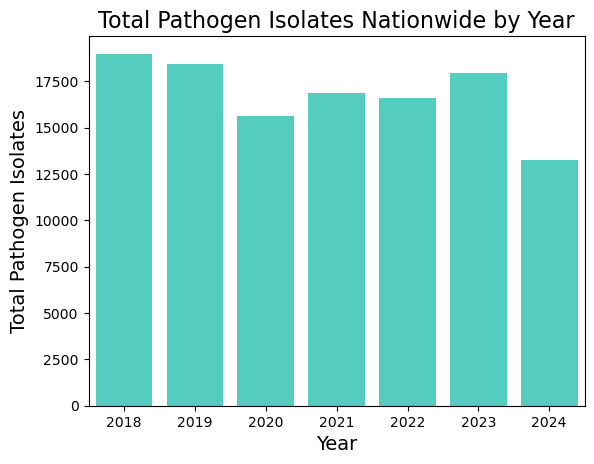

In [50]:
# code originator: Sophia

# visualizing total pathogen isolates nationwide by year
sns.barplot(x='year', y='Total', data=counts_per_year, color='turquoise')
plt.title('Total Pathogen Isolates Nationwide by Year', fontsize = 16)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Total Pathogen Isolates', fontsize = 14)
plt.show()

### Analyzing the number of cases per pathogen type per month

In [51]:
# code originator: Sophia

# create a dataframe counts_per_month
counts_per_month = merged_df.groupby(['month', 'pathogen']).size().unstack(fill_value=0)
counts_per_month['Total'] = counts_per_month['Campylobacter'] + counts_per_month['STEC'] + counts_per_month['Salmonella'] + counts_per_month['Shigella'] + counts_per_month['Vibrio']
counts_per_month.head()

pathogen,Campylobacter,STEC,Salmonella,Shigella,Vibrio,Total
month,,,,,,
1,335,0,8108,0,43,8486
2,310,0,6880,0,36,7226
3,321,0,7680,2,53,8056
4,333,1,8395,2,50,8781
5,369,0,9861,2,90,10322


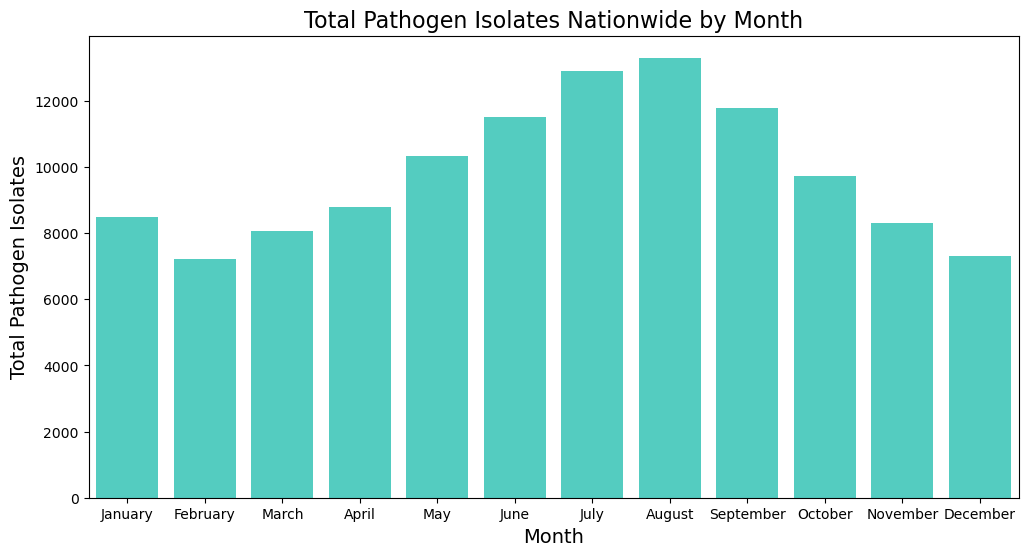

In [52]:
# code originator: Sophia

# visualizing total pathogen isolates nationwide by month
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='month', y='Total', data=counts_per_month, color='turquoise')
plt.title('Total Pathogen Isolates Nationwide by Month', fontsize=16)
plt.xlabel('Month', fontsize = 14)
ax.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.ylabel('Total Pathogen Isolates', fontsize = 14)
plt.show()

### Analyzing the cases per quarter (i.e. 2018 Q1, 2018 Q2, etc.)

In [53]:
# code originator: Sophia

# create the 'date' column
merged_df['date'] = pd.to_datetime(merged_df[['year', 'month']].assign(day=1))

# group by quarter and sum num_isolates
quarterly_data = (
    merged_df.groupby(pd.Grouper(key='date', freq='Q'))['num_isolates']
    .sum()
    .reset_index()
)

# add a column for the quarter (Q1, Q2, etc.)
quarterly_data['quarter_label'] = 'Q' + quarterly_data['date'].dt.quarter.astype(str)

# rename columns for clarity
quarterly_data.rename(columns={'date': 'quarter', 'num_isolates': 'total_isolates'}, inplace=True)

quarterly_data.head()

,quarter,total_isolates,quarter_label
0,2018-03-31,8268,Q1
1,2018-06-30,13954,Q2
2,2018-09-30,21647,Q3
3,2018-12-31,12663,Q4
4,2019-03-31,7955,Q1


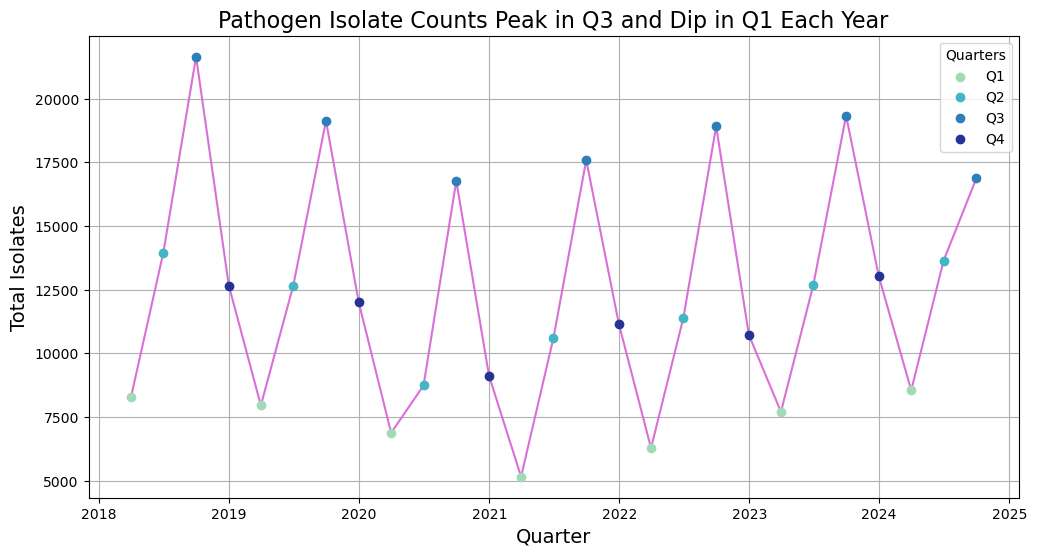

In [54]:
# code originator: Sophia

# define colors for each quarter
quarter_colors = {
    'Q1': '#a1dab4',
    'Q2': '#41b6c4',
    'Q3': '#2c7fb8',
    'Q4': '#253494'
}

# assume quarterly_data['quarter'] contains quarter labels like Q1, Q2, etc.

plt.figure(figsize=(12, 6))

# plot the line as usual
plt.plot(quarterly_data['quarter'], quarterly_data['total_isolates'], marker='', linestyle='-', color='orchid')

# plot points with consistent colors based on the quarter
for i in range(len(quarterly_data)):
    quarter_label = quarterly_data['quarter_label'][i]  # get the quarter label (e.g., 'Q1')
    color = quarter_colors.get(quarter_label, 'black')  # default to 'black' if quarter not found
    plt.scatter(quarterly_data['quarter'][i], quarterly_data['total_isolates'][i], color=color, zorder=5)

plt.title('Pathogen Isolate Counts Peak in Q3 and Dip in Q1 Each Year', fontsize=16)
plt.xlabel('Quarter', fontsize=14)
plt.ylabel('Total Isolates', fontsize=14)
plt.grid(True)

# add a legend for the quarter colors
for quarter, color in quarter_colors.items():
    plt.scatter([], [], color=color, label=quarter)  # Dummy scatter for legend
plt.legend(title="Quarters")

plt.show()

### Analyzing the cases per source type

In [55]:
counts_per_source = merged_df.groupby(['year', 'source']).size().unstack(fill_value=0)
counts_per_source.head()

source,Blood,Other,Stool,Urine
year,,,,
2018,2250,1696,12061,2981
2019,2320,1545,11610,2984
2020,2093,1158,9627,2762
2021,2355,1142,10263,3104
2022,2421,1086,10041,3071


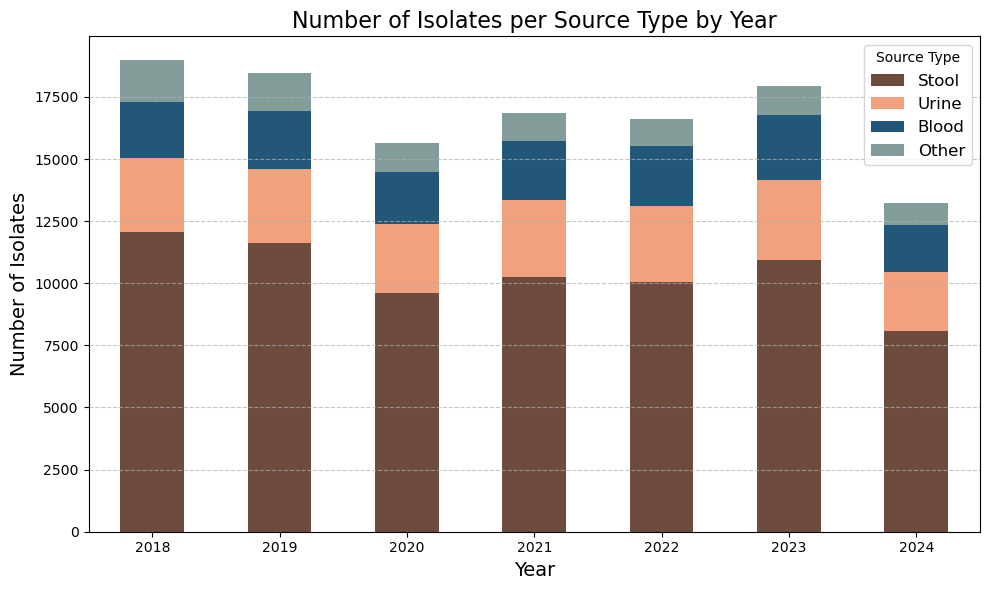

In [56]:
counts_per_source = counts_per_source[
    counts_per_source.sum(axis=0).sort_values(ascending=False).index
]
counts_per_source.head()

# plot stacked bar plot
counts_per_source.plot(
    kind='bar', 
    stacked=True, 
    figsize=(10, 6), 
    rot=0, 
    color=['#6D4C3D', '#F1A17E', '#22577A', '#839D9A']
)

# add titles and labels
plt.title('Number of Isolates per Source Type by Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Isolates', fontsize=14)
plt.legend(title='Source Type', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Geospatial Analyses

In [57]:
merged_df.head()

,year,month,state,source,pathogen,serotype_species,num_isolates,geometry,date
0,2024,1,AK,Stool,Campylobacter,jejuni,1,"MULTIPOLYGON (((-2778499.467 -1620603.792, -27...",2024-01-01
1,2024,1,AL,Stool,Campylobacter,coli,1,"POLYGON ((1023282.917 -582853.454, 1023269.168...",2024-01-01
2,2024,1,AL,Stool,Campylobacter,jejuni,2,"POLYGON ((1023282.917 -582853.454, 1023269.168...",2024-01-01
3,2024,1,AR,Stool,Campylobacter,jejuni,1,"POLYGON ((461603.731 -366288.124, 461727.959 -...",2024-01-01
4,2024,1,CA,Stool,Campylobacter,jejuni,1,"MULTIPOLYGON (((-1976277.366 663684.581, -1976...",2024-01-01


In [58]:
merged_df['num_isolates'] = merged_df['num_isolates'].astype(int)
# sum the isolates by year and state
annual_state_isolates = merged_df.groupby(['year', 'state']).agg({'num_isolates': 'sum', 'geometry': 'first'}).reset_index()

# convert GeoDataFrame
annual_state_isolates = gpd.GeoDataFrame(annual_state_isolates, geometry='geometry')

annual_state_isolates.head()

,year,state,num_isolates,geometry
0,2018,AK,152,"MULTIPOLYGON (((-2778499.467 -1620603.792, -27..."
1,2018,AL,751,"POLYGON ((1023282.917 -582853.454, 1023269.168..."
2,2018,AR,791,"POLYGON ((461603.731 -366288.124, 461727.959 -..."
3,2018,AZ,1034,"POLYGON ((-1295161.727 45024.154, -1294397.086..."
4,2018,CA,5651,"MULTIPOLYGON (((-1976277.366 663684.581, -1976..."


### Analyzing states with high pathogen counts (CA, TX, FL)

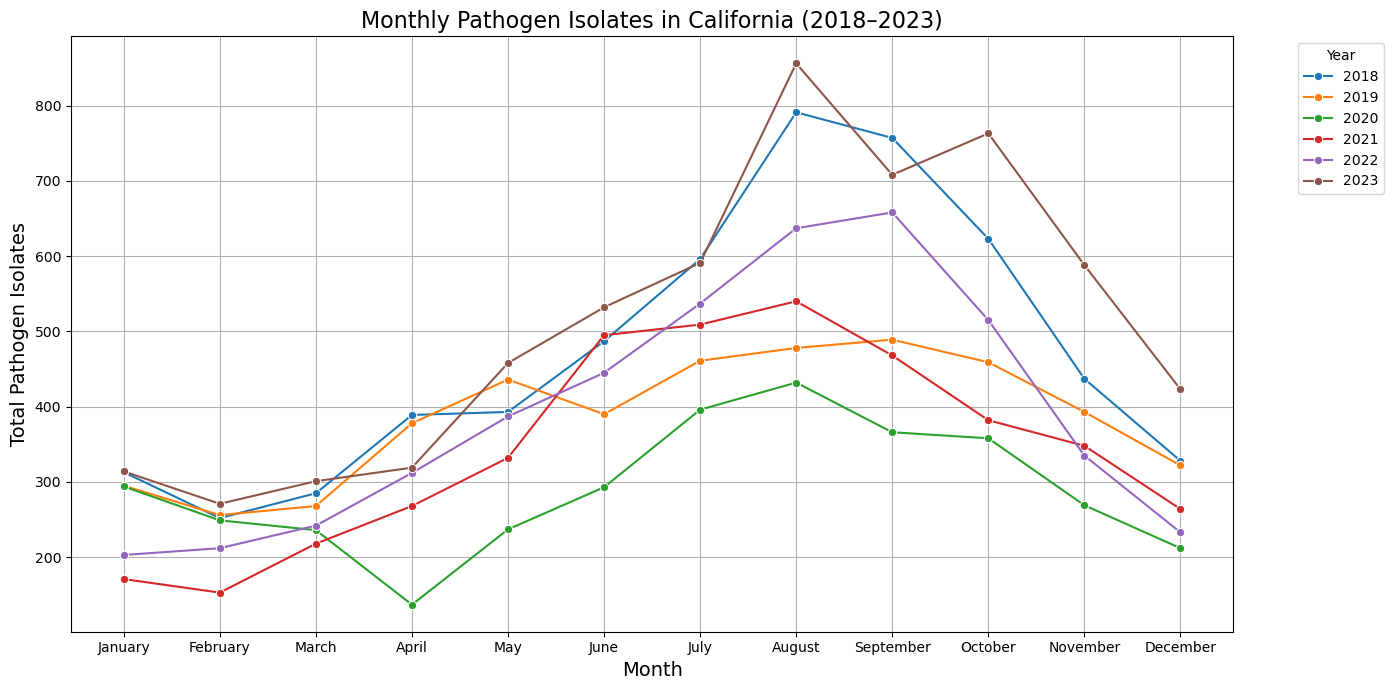

In [59]:
# code originator: Nikki

ca_data = merged_df[merged_df['state'] == 'CA']

# for California
ca_monthly = ca_data.groupby(['year', 'month']).agg({'num_isolates': 'sum'}).reset_index()


# for years 2018–2023
ca_filtered = ca_monthly[(ca_monthly['year'] >= 2018) & (ca_monthly['year'] <= 2023)]

# month numbers to names
month_names = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 
               7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
ca_filtered['month'] = ca_filtered['month'].map(month_names)

plt.figure(figsize=(14, 7))
sns.lineplot(x='month', y='num_isolates', hue='year', data=ca_filtered, marker='o', palette='tab10')
plt.title('Monthly Pathogen Isolates in California (2018–2023)', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Total Pathogen Isolates', fontsize=14)
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


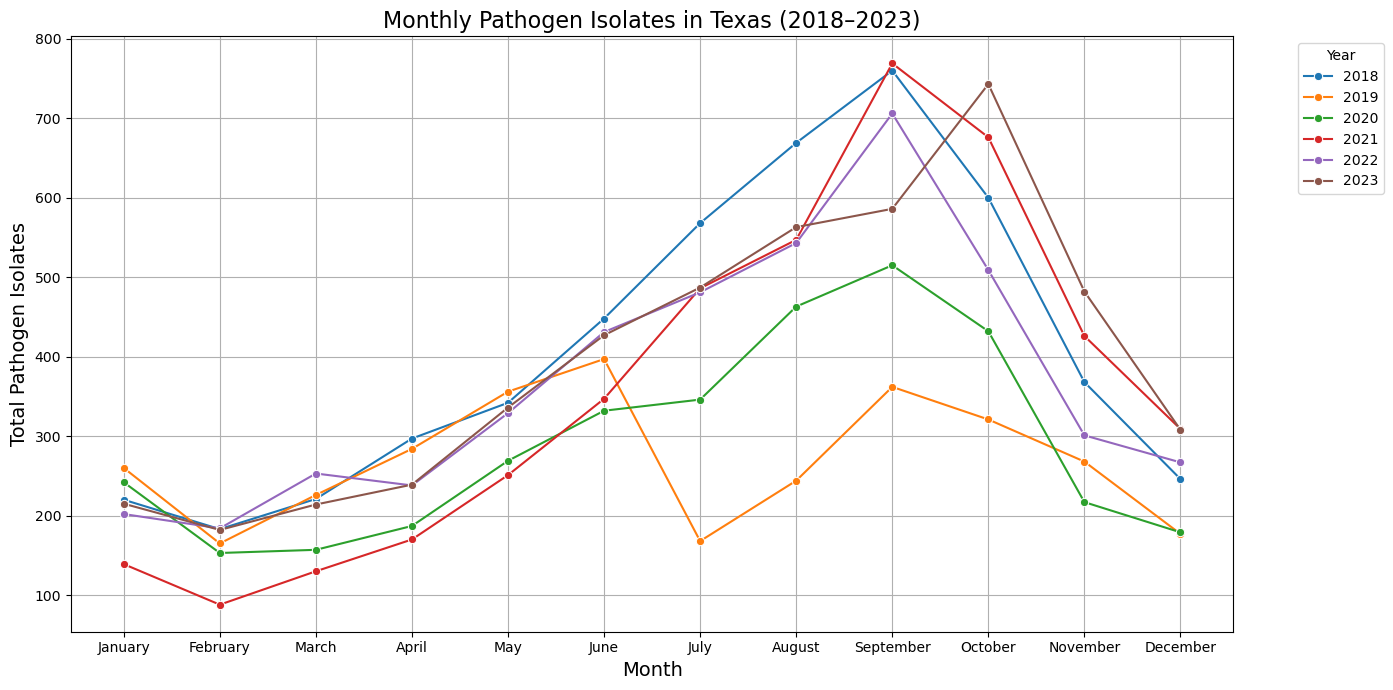

In [60]:
# code originator: Nikki

tx_data = merged_df[merged_df['state'] == 'TX']

# for Texas
tx_monthly = tx_data.groupby(['year', 'month']).agg({'num_isolates': 'sum'}).reset_index()

# for years 2018–2023
tx_filtered = tx_monthly[(tx_monthly['year'] >= 2018) & (tx_monthly['year'] <= 2023)]

# month numbers to names
month_names = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 
               7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
tx_filtered['month'] = tx_filtered['month'].map(month_names)

plt.figure(figsize=(14, 7))
sns.lineplot(x='month', y='num_isolates', hue='year', data=tx_filtered, marker='o', palette='tab10')
plt.title('Monthly Pathogen Isolates in Texas (2018–2023)', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Total Pathogen Isolates', fontsize=14)
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


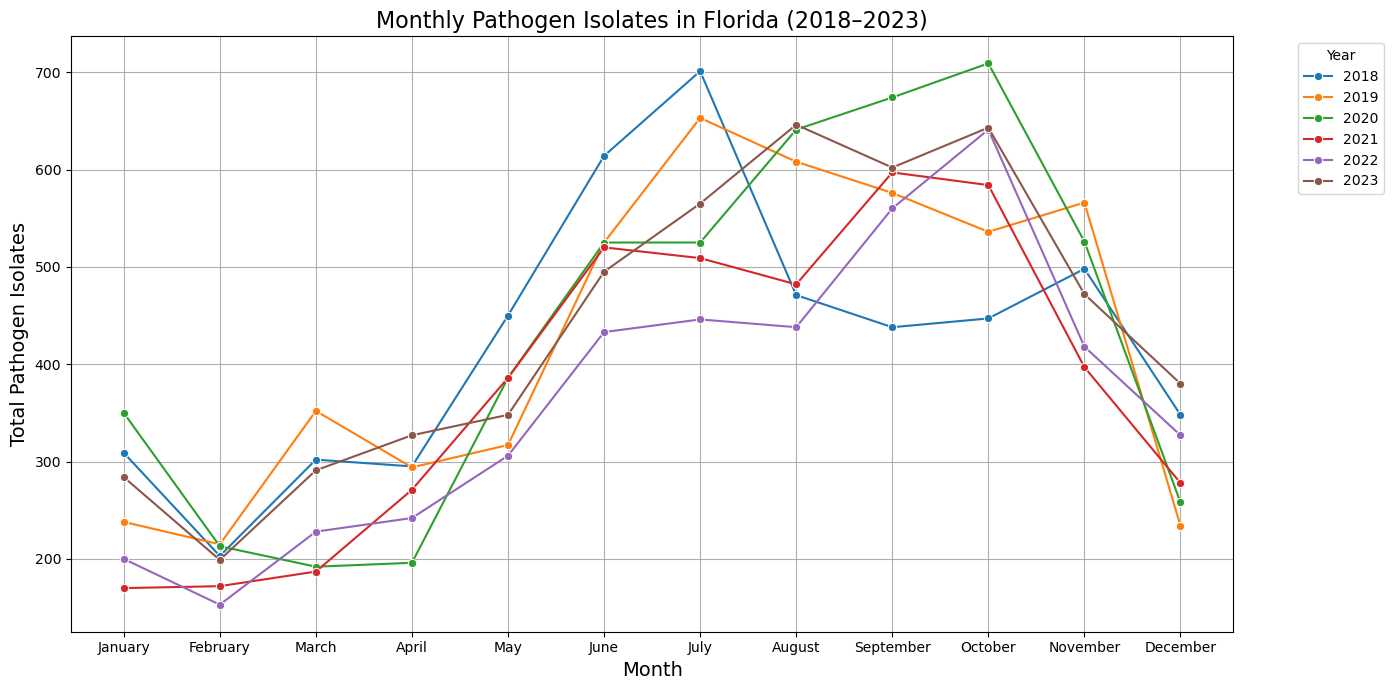

In [61]:
# code originator: Nikki

fl_data = merged_df[merged_df['state'] == 'FL']

# for Florida
fl_monthly = fl_data.groupby(['year', 'month']).agg({'num_isolates': 'sum'}).reset_index()

# for years 2018–2023
fl_filtered = fl_monthly[(fl_monthly['year'] >= 2018) & (fl_monthly['year'] <= 2023)]

# month numbers to names
month_names = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 
               7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
fl_filtered['month'] = fl_filtered['month'].map(month_names)

plt.figure(figsize=(14, 7))
sns.lineplot(x='month', y='num_isolates', hue='year', data=fl_filtered, marker='o', palette='tab10')
plt.title('Monthly Pathogen Isolates in Florida (2018–2023)', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Total Pathogen Isolates', fontsize=14)
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [62]:
# code originator: Nikki

states_data = merged_df[merged_df['state'].isin(['CA', 'TX', 'FL'])]

# summing the number of isolates
state_pathogen_counts = states_data.groupby(['state', 'pathogen']).agg({'num_isolates': 'sum'}).unstack(fill_value=0)
state_pathogen_counts.columns = state_pathogen_counts.columns.droplevel(0)

state_pathogen_counts

pathogen,Campylobacter,STEC,Salmonella,Shigella,Vibrio
state,,,,,
CA,582,0,32183,0,92
FL,36,1,32736,0,335
TX,108,41,28784,82,174


### Analyzing total pathogen counts by state per capita (Rishabh)

In [63]:
# code originator: Rishabh

# remove District of Columbia because it is not a state
census_df = census_df[census_df["Geographic Region"] != "District of Columbia"]

In [64]:
# uncommment this block in case the following code block runs into errors
from us import states

In [65]:
# code originator: Rishabh
# automatically map state names to abbreviations
census_df["state"] = census_df["Geographic Region"].apply(lambda x: states.lookup(x).abbr if states.lookup(x) else None)
census_df.head()

,Geographic Region,2018,2019,2020,2021,2022,2023,state
0,United States,"32,66,87,501","32,82,39,523","33,15,26,933","33,20,48,977","33,32,71,411","33,49,14,895",None
1,Alabama,"48,87,681","49,03,185","50,31,864","50,50,380","50,73,903","51,08,468",AL
2,Alaska,"7,35,139","7,31,545","7,32,964","7,34,923","7,33,276","7,33,406",AK
3,Arizona,"71,58,024","72,78,717","71,86,683","72,72,487","73,65,684","74,31,344",AZ
4,Arkansas,"30,09,733","30,17,804","30,14,348","30,28,443","30,46,404","30,67,732",AR


In [66]:
# code originator: Rishabh

# check for unmatched geographic regions
unmatched = census_df[census_df["state"].isnull()]
if not unmatched.empty:
    print("Unmatched Geographic Regions:")
    print(unmatched)

Unmatched Geographic Regions:
  Geographic Region          2018          2019          2020          2021  \
0     United States  32,66,87,501  32,82,39,523  33,15,26,933  33,20,48,977   

           2022          2023 state  
0  33,32,71,411  33,49,14,895  None  


In [67]:
# code originator: Rishabh

# prepare population data for all years
# census data placed commas in strange places so we have removed them below
state_population = census_df[["state", "2018", "2019", "2020", "2021", "2022", "2023"]]
for year in ["2018", "2019", "2020", "2021", "2022", "2023"]:
    state_population[year] = state_population[year].str.replace(",", "").astype(float)

In [68]:
# code originator: Rishabh

for year in range(2018, 2024):
    state_population_year = census_df[["state", str(year)]].rename(columns={str(year): "population"})
    state_population_year["population"] = state_population_year["population"].str.replace(",", "").astype(float)
    year_data = annual_state_isolates[annual_state_isolates["year"] == year]
    year_data = year_data.merge(state_population_year, how="left", on="state")
    year_data["pathogen_per_capita"] = year_data["num_isolates"] / year_data["population"]
    census_df = census_df.merge(
        year_data[["state", "num_isolates", "pathogen_per_capita"]],
        how="left",
        on="state"
    )
    census_df.rename(
        columns={
            "num_isolates": f"pathogen_count_{year}",
            "pathogen_per_capita": f"pathogen_per_capita_{year}"
        },
        inplace=True
    )

print(census_df.head())

  Geographic Region          2018          2019          2020          2021  \
0     United States  32,66,87,501  32,82,39,523  33,15,26,933  33,20,48,977   
1           Alabama     48,87,681     49,03,185     50,31,864     50,50,380   
2            Alaska      7,35,139      7,31,545      7,32,964      7,34,923   
3           Arizona     71,58,024     72,78,717     71,86,683     72,72,487   
4          Arkansas     30,09,733     30,17,804     30,14,348     30,28,443   

           2022          2023 state  pathogen_count_2018  \
0  33,32,71,411  33,49,14,895  None                  NaN   
1     50,73,903     51,08,468    AL                751.0   
2      7,33,276      7,33,406    AK                152.0   
3     73,65,684     74,31,344    AZ               1034.0   
4     30,46,404     30,67,732    AR                791.0   

   pathogen_per_capita_2018  pathogen_count_2019  pathogen_per_capita_2019  \
0                       NaN                  NaN                       NaN   
1       

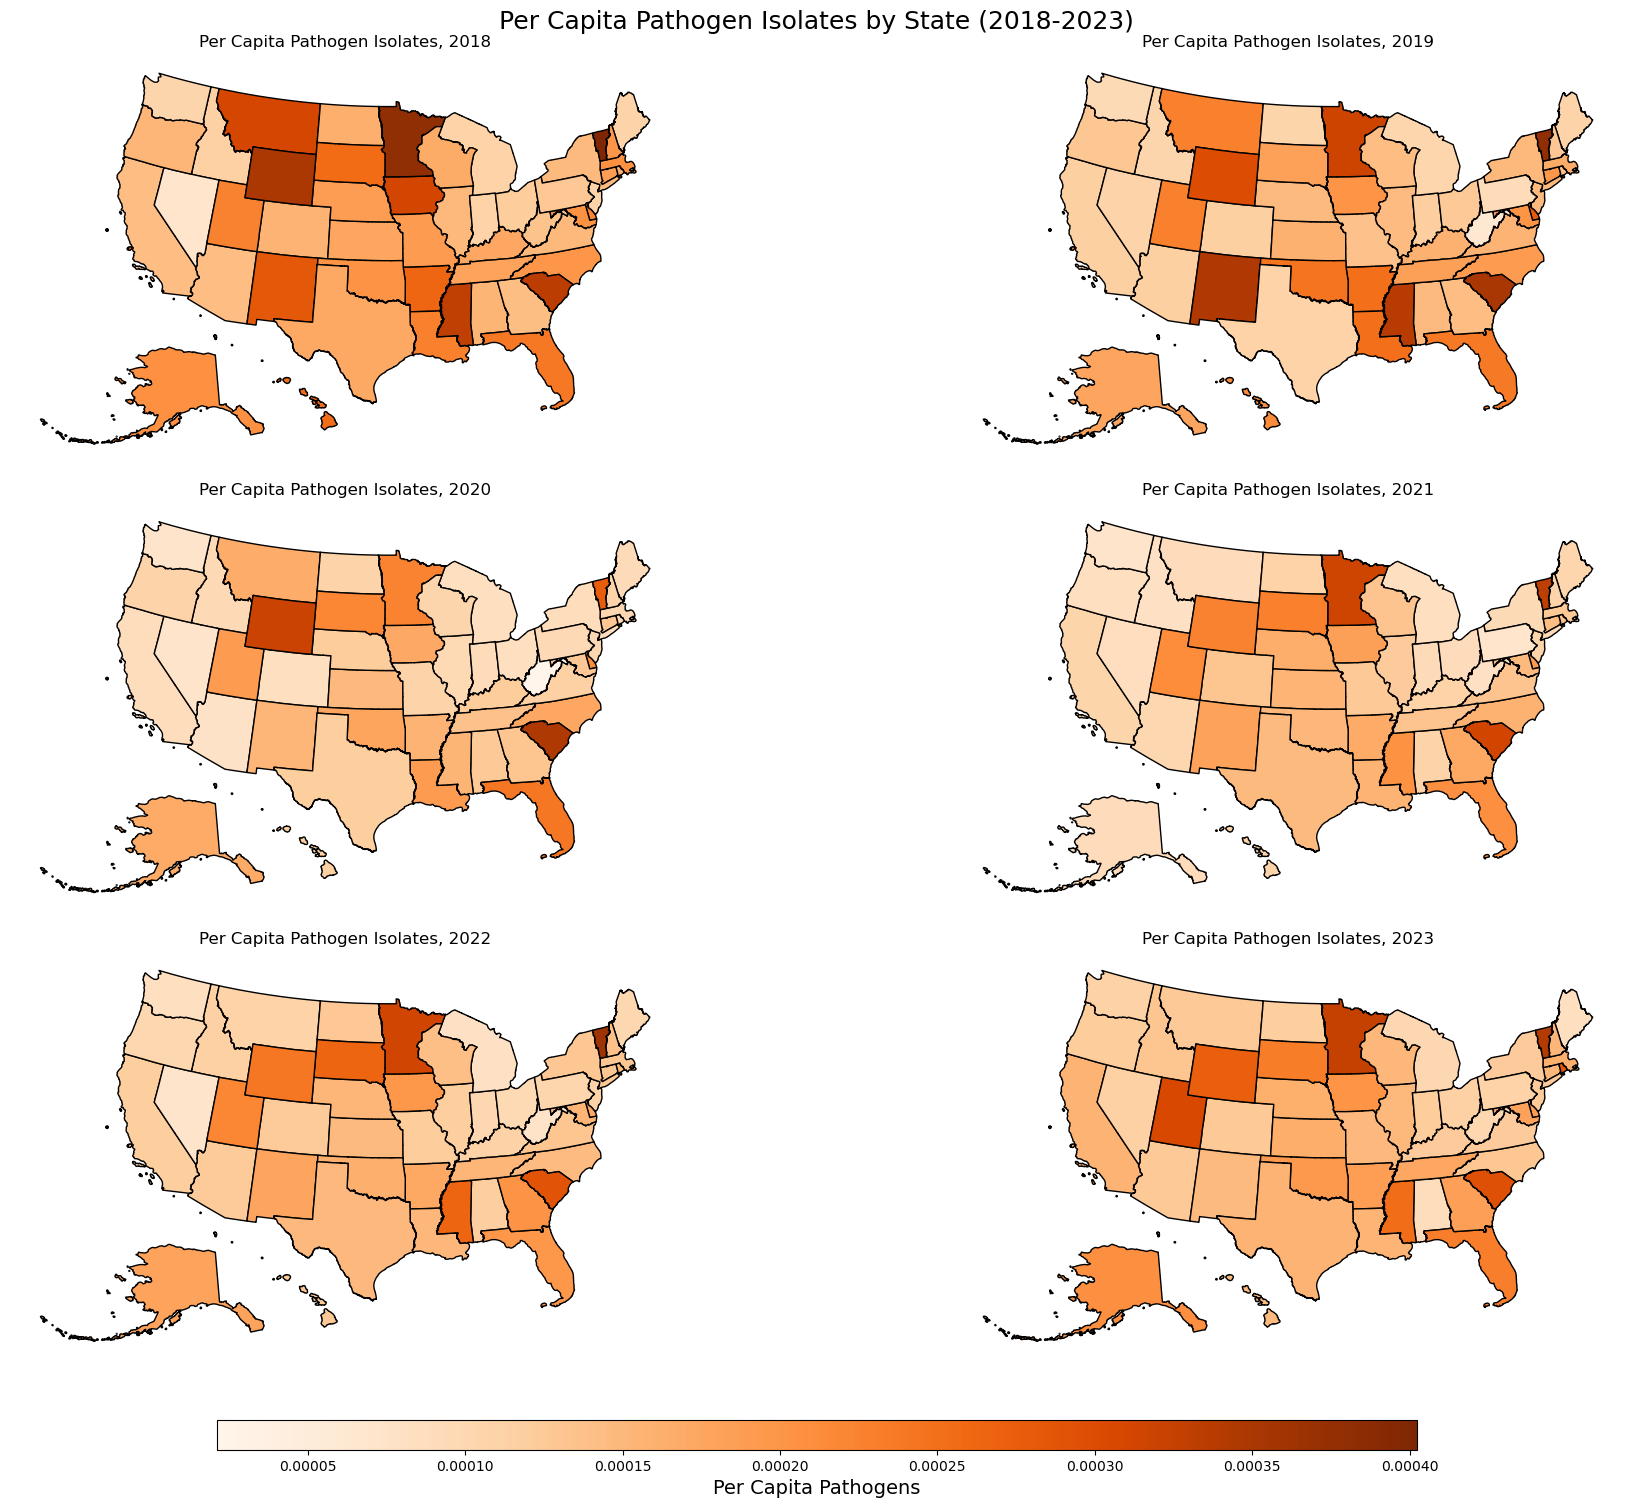

In [69]:
# code originator: Rishabh

# loop through each year and visualize per capita pathogen counts
years = range(2018, 2024)

fig, axes = plt.subplots(3, 2, figsize=(20, 15))
axes = axes.flatten()

all_years_data = []
for year in years:
    state_population_year = state_population[["state", str(year)]].rename(columns={str(year): "population"})
    pathogen_per_capita = annual_state_isolates.merge(state_population_year, how="left", on="state")
    pathogen_per_capita["per_capita_pathogens"] = pathogen_per_capita["num_isolates"] / pathogen_per_capita["population"]
    all_years_data.append(pathogen_per_capita)

all_data_combined = pd.concat(all_years_data)
vmin = all_data_combined["per_capita_pathogens"].min()
vmax = all_data_combined["per_capita_pathogens"].max()

for i, year in enumerate(years):
    ax = axes[i]
    state_population_year = state_population[["state", str(year)]].rename(columns={str(year): "population"})
    pathogen_per_capita = annual_state_isolates.merge(state_population_year, how="left", on="state")
    pathogen_per_capita["per_capita_pathogens"] = pathogen_per_capita["num_isolates"] / pathogen_per_capita["population"]
    year_data = pathogen_per_capita[pathogen_per_capita["year"] == year]
    
    year_data.plot(column="per_capita_pathogens", ax=ax, legend=False, cmap="Oranges", edgecolor="black", vmin=vmin, vmax=vmax)
    ax.set_title(f"Per Capita Pathogen Isolates, {year}", fontsize=12)
    ax.set_axis_off()

cbar_ax = fig.add_axes([0.2, 0.02, 0.6, 0.02])
sm = plt.cm.ScalarMappable(cmap="Oranges", norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal")
cbar.set_label("Per Capita Pathogens", fontsize=14)

fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.08, wspace=0.1, hspace=0.1)
fig.suptitle("Per Capita Pathogen Isolates by State (2018-2023)", fontsize=18)

plt.show()

### Analyzing total pathogen counts by state public health funding per capita

In [70]:
# code originator: Rishabh
 
# add column of state abbreviations
state_to_abbrev = {state.name: state.abbr for state in states.STATES}
funding_df['state_abbrev'] = funding_df['location'].map(state_to_abbrev)
funding_df.head()

,Unnamed: 0,state_idx,location,year,currency,funding,state_abbrev
0,0,1,Alabama,2018,Dollars,57.23,AL
1,1,1,Alabama,2019,Dollars,54.25,AL
2,2,1,Alabama,2020,Dollars,46.81,AL
3,3,1,Alabama,2021,Dollars,52.35,AL
4,4,1,Alabama,2022,Dollars,49.48,AL


In [71]:
# code originator: Sophia

# drop unnecessary columns
funding_df = funding_df.drop(['Unnamed: 0', 'state_idx', 'currency'], axis=1)
funding_df.head()

,location,year,funding,state_abbrev
0,Alabama,2018,57.23,AL
1,Alabama,2019,54.25,AL
2,Alabama,2020,46.81,AL
3,Alabama,2021,52.35,AL
4,Alabama,2022,49.48,AL


In [72]:
# code originator: Sophia

# check funding for missing values
funding_df.isna().sum()

location         0
year             0
funding         10
state_abbrev     6
dtype: int64

In [73]:
# code originator: Sophia

# check which rows are missing state abbreviations
funding_df[funding_df['state_abbrev'].isna() == True]

,location,year,funding,state_abbrev
48,Dist. of Columbia,2018,134.96,NaN
49,Dist. of Columbia,2019,363.18,NaN
50,Dist. of Columbia,2020,364.53,NaN
51,Dist. of Columbia,2021,370.56,NaN
52,Dist. of Columbia,2022,421.94,NaN
53,Dist. of Columbia,2023,423.21,NaN


In [74]:
# code originator: Sophia

# remove rows for Washington D.C. because it is not technically a state and we do not have data on the area
funding_df = funding_df[funding_df['location'] != 'Dist. of Columbia']

In [75]:
# code originator: Sophia

# check for missing funding values
funding_df[funding_df['funding'].isna() == True]

,location,year,funding,state_abbrev
45,Delaware,2021,NaN,DE
70,Hawaii,2022,NaN,HI
99,Kansas,2021,NaN,KS
124,Maryland,2022,NaN,MD
136,Michigan,2022,NaN,MI
173,Nevada,2023,NaN,NV
237,Rhode Island,2021,NaN,RI
267,Utah,2021,NaN,UT
291,West Virginia,2021,NaN,WV
293,West Virginia,2023,NaN,WV


Since the funding df contains years and the missing funding rows are all a couple of years after the first data points per state, we chose to use forward fill to fill in missing values.

In [76]:
# code originator: Rishabh

# forward fill in missing values
funding_df.sort_values(by=["state_abbrev", "year"], inplace=True)
funding_df["funding"] = funding_df.groupby("state_abbrev")["funding"].ffill()

# check that missing values are filled in
print(funding_df[funding_df["funding"].isna()])
funding_df.head()


Empty DataFrame
Columns: [location, year, funding, state_abbrev]
Index: []


,location,year,funding,state_abbrev
6,Alaska,2018,96.52,AK
7,Alaska,2019,98.25,AK
8,Alaska,2020,215.15,AK
9,Alaska,2021,90.17,AK
10,Alaska,2022,91.15,AK


In [77]:
# code originator: Rishabh

# breaking up state funding data into df by year
funding_2018 = funding_df[funding_df['year'] == 2018]
funding_2019 = funding_df[funding_df['year'] == 2019]
funding_2020 = funding_df[funding_df['year'] == 2020]
funding_2021 = funding_df[funding_df['year'] == 2021]
funding_2022 = funding_df[funding_df['year'] == 2022]
funding_2023 = funding_df[funding_df['year'] == 2023]

In [78]:
# code originator: Rishabh

funding_df.rename(columns={"state_abbrev": "state"}, inplace=True)

In [79]:
# code originator: Rishabh

# merge with merged_df on the state 
merged_yearly_dfs = []

for year in range(2018, 2024):
    funding_year = funding_df[funding_df['year'] == year][['state', 'funding']]
    merged_year = merged_df[merged_df['year'] == year].merge(
        funding_year,
        how='left',
        on='state'
    )
    merged_yearly_dfs.append(merged_year)

merged_funding_df = pd.concat(merged_yearly_dfs, ignore_index=True)

In [80]:
merged_funding_df.head()

,year,month,state,source,pathogen,serotype_species,num_isolates,geometry,date,funding
0,2018,1,AK,Stool,Campylobacter,coli,1,"MULTIPOLYGON (((-2778499.467 -1620603.792, -27...",2018-01-01,96.52
1,2018,1,AK,Stool,Campylobacter,jejuni,4,"MULTIPOLYGON (((-2778499.467 -1620603.792, -27...",2018-01-01,96.52
2,2018,1,AK,Stool,Campylobacter,upsaliensis,1,"MULTIPOLYGON (((-2778499.467 -1620603.792, -27...",2018-01-01,96.52
3,2018,1,AL,Stool,Campylobacter,coli,1,"POLYGON ((1023282.917 -582853.454, 1023269.168...",2018-01-01,57.23
4,2018,1,AL,Stool,Campylobacter,jejuni,3,"POLYGON ((1023282.917 -582853.454, 1023269.168...",2018-01-01,57.23


In [81]:
census_df.head()

,Geographic Region,2018,2019,2020,2021,2022,2023,state,pathogen_count_2018,pathogen_per_capita_2018,pathogen_count_2019,pathogen_per_capita_2019,pathogen_count_2020,pathogen_per_capita_2020,pathogen_count_2021,pathogen_per_capita_2021,pathogen_count_2022,pathogen_per_capita_2022,pathogen_count_2023,pathogen_per_capita_2023
0,United States,"32,66,87,501","32,82,39,523","33,15,26,933","33,20,48,977","33,32,71,411","33,49,14,895",None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Alabama,"48,87,681","49,03,185","50,31,864","50,50,380","50,73,903","51,08,468",AL,751.0,0.000154,719.0,0.000147,633.0,0.000126,544.0,0.000108,604.0,0.000119,452.0,0.000088
2,Alaska,"7,35,139","7,31,545","7,32,964","7,34,923","7,33,276","7,33,406",AK,152.0,0.000207,129.0,0.000176,124.0,0.000169,66.0,0.000090,132.0,0.000180,152.0,0.000207
3,Arizona,"71,58,024","72,78,717","71,86,683","72,72,487","73,65,684","74,31,344",AZ,1034.0,0.000144,851.0,0.000117,553.0,0.000077,741.0,0.000102,919.0,0.000125,940.0,0.000126
4,Arkansas,"30,09,733","30,17,804","30,14,348","30,28,443","30,46,404","30,67,732",AR,791.0,0.000263,757.0,0.000251,474.0,0.000157,513.0,0.000169,523.0,0.000172,572.0,0.000186


In [82]:
# code originator: Rishabh

# extract the first unique value of funding for each state and year
unique_funding = merged_funding_df.groupby(["state", "year"]).first().reset_index()

# retain only the relevant columns
unique_funding = unique_funding[["state", "year", "funding", "geometry"]]

# pivot the data to wide format with states as rows and years as columns
funding_wide = unique_funding.pivot(index=["state", "geometry"], columns="year", values="funding").reset_index()

# rename columns for clarity
funding_wide.columns.name = None  # remove multi-index column name
funding_wide = funding_wide.rename(columns=lambda x: f"funding_{x}" if isinstance(x, int) else x)

# display the resulting DataFrame
print(funding_wide.head())


  state                                           geometry  funding_2018  \
0    AK  MULTIPOLYGON (((-2778499.467 -1620603.792, -27...         96.52   
1    AL  POLYGON ((1023282.917 -582853.454, 1023269.168...         57.23   
2    AR  POLYGON ((461603.731 -366288.124, 461727.959 -...         50.57   
3    AZ  POLYGON ((-1295161.727 45024.154, -1294397.086...          9.66   
4    CA  MULTIPOLYGON (((-1976277.366 663684.581, -1976...         65.71   

   funding_2019  funding_2020  funding_2021  funding_2022  funding_2023  
0         98.25        215.15         90.17         91.15         87.85  
1         54.25         46.81         52.35         49.48         51.89  
2         48.23         45.90         42.94         45.34         44.89  
3         15.25         24.34         15.32         16.57         28.15  
4         71.89         69.87         78.47        130.29         84.17  


In [83]:
# code originator: Rishabh

# merge funding data with pathogen counts
adjusted_df = census_df.merge(
    funding_wide,
    on="state",
    how="left"  # keep all states, even if some don't match
)
print(adjusted_df.head())

  Geographic Region          2018          2019          2020          2021  \
0     United States  32,66,87,501  32,82,39,523  33,15,26,933  33,20,48,977   
1           Alabama     48,87,681     49,03,185     50,31,864     50,50,380   
2            Alaska      7,35,139      7,31,545      7,32,964      7,34,923   
3           Arizona     71,58,024     72,78,717     71,86,683     72,72,487   
4          Arkansas     30,09,733     30,17,804     30,14,348     30,28,443   

           2022          2023 state  pathogen_count_2018  \
0  33,32,71,411  33,49,14,895  None                  NaN   
1     50,73,903     51,08,468    AL                751.0   
2      7,33,276      7,33,406    AK                152.0   
3     73,65,684     74,31,344    AZ               1034.0   
4     30,46,404     30,67,732    AR                791.0   

   pathogen_per_capita_2018  ...  pathogen_per_capita_2022  \
0                       NaN  ...                       NaN   
1                  0.000154  ...        

In [84]:
# code originator: Rishabh

years = range(2018, 2024)

for year in years:
    adjusted_df[f"adjusted_illnesses_{year}"] = (
        adjusted_df[f"pathogen_count_{year}"] / adjusted_df[f"funding_{year}"]
    )

In [85]:
# code originator: Rishabh

# check the adjusted data for Alabama (AL) for 2018
print("Adjusted DataFrame for Alaska (AK) in 2018:")
alabama_2018 = adjusted_df[adjusted_df["state"] == "AK"][
    ["state", "pathogen_count_2018", "funding_2018", "adjusted_illnesses_2018"]
]
print(alabama_2018)

Adjusted DataFrame for Alaska (AK) in 2018:
  state  pathogen_count_2018  funding_2018  adjusted_illnesses_2018
2    AK                152.0         96.52                 1.574803


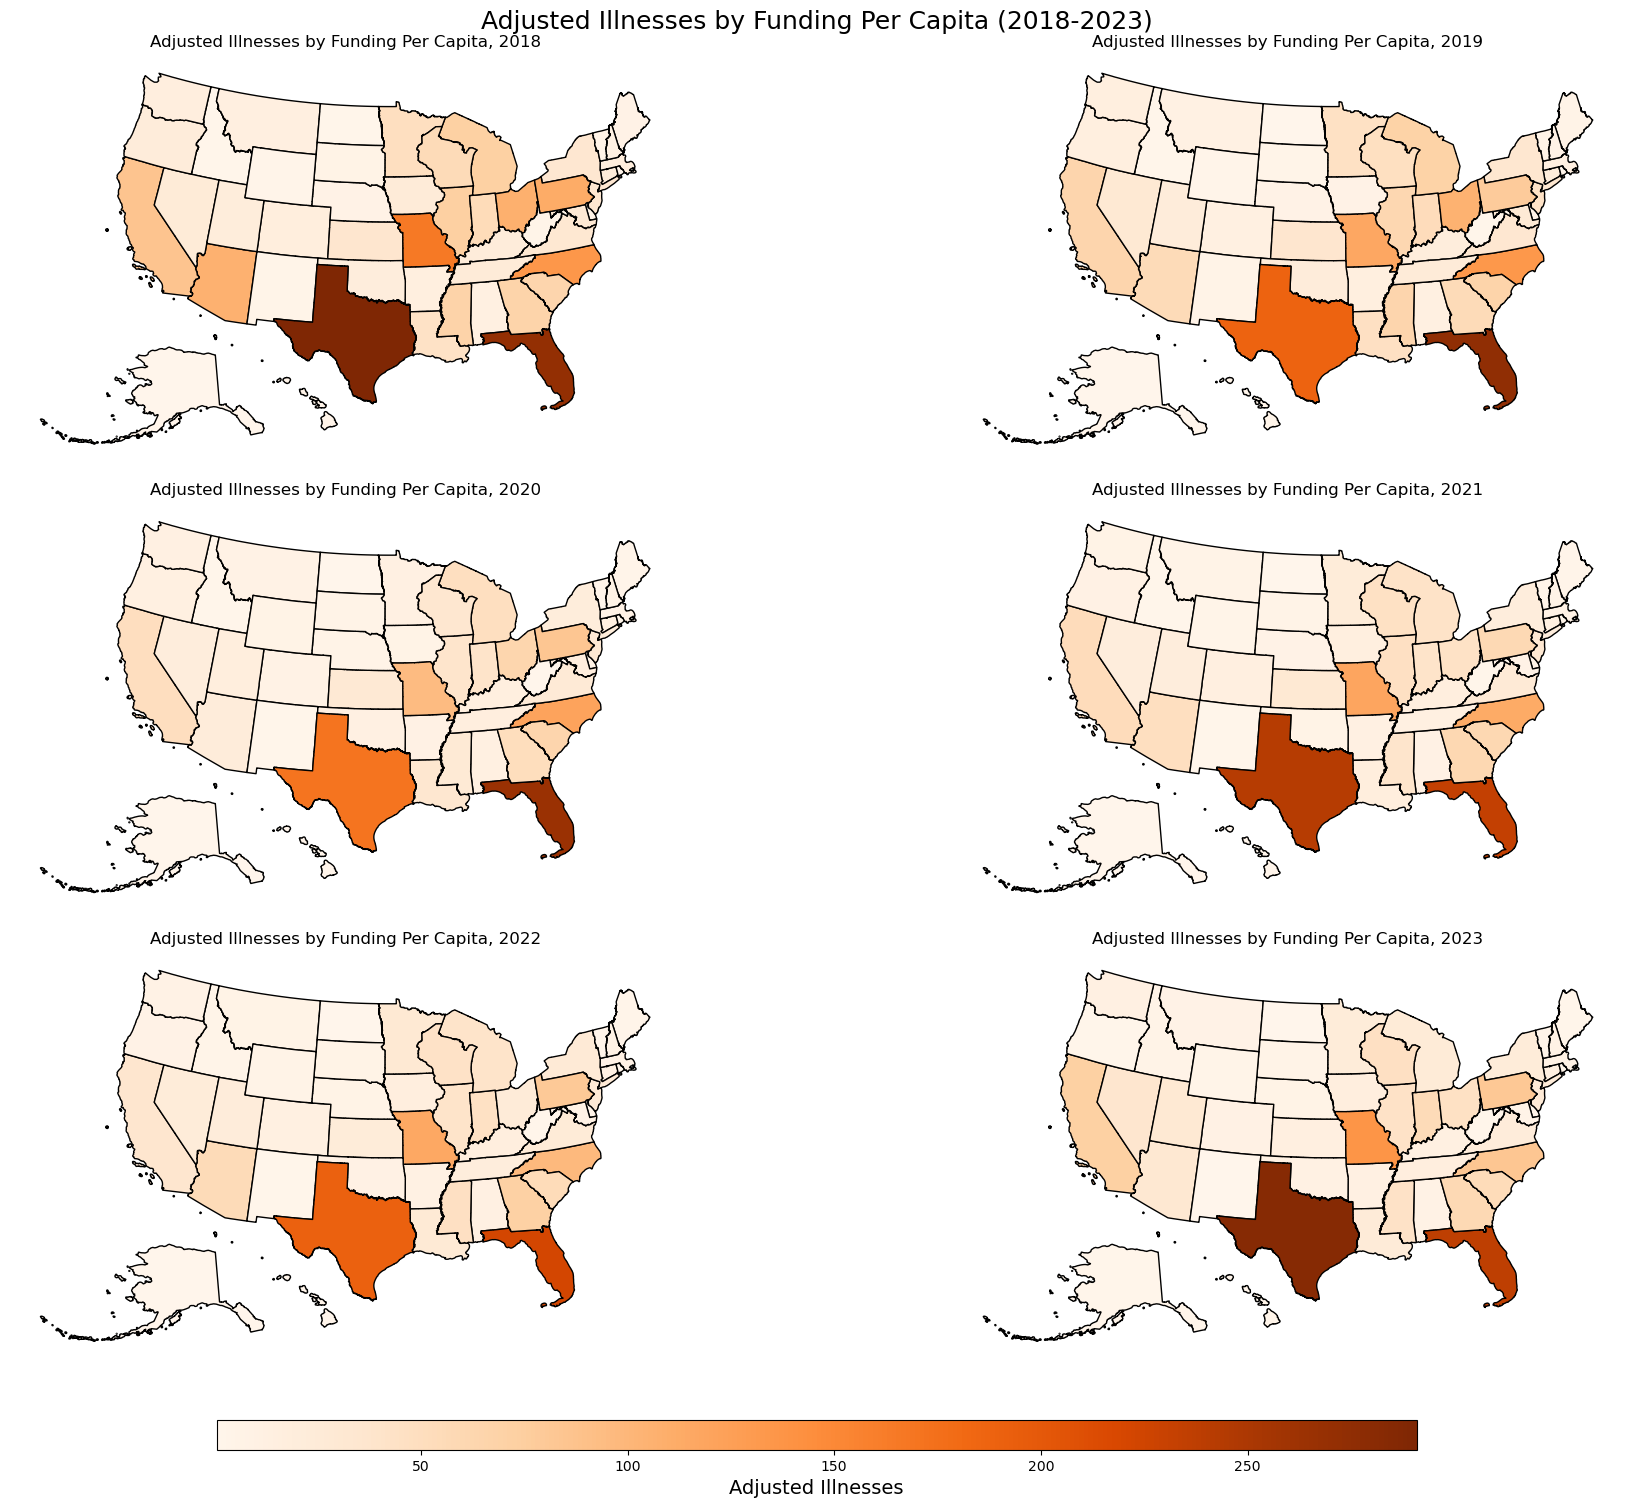

In [86]:
# code originator: Rishabh

# loop through each year and visualize adjusted illnesses by funding per capita
years = range(2018, 2024)

fig, axes = plt.subplots(3, 2, figsize=(20, 15))
axes = axes.flatten()

all_values = []
for year in years:
    year_data = adjusted_df[["state", "geometry", f"adjusted_illnesses_{year}"]].dropna()
    all_values.extend(year_data[f"adjusted_illnesses_{year}"].values)

vmin = min(all_values)
vmax = max(all_values)

for i, year in enumerate(years):
    year_data = adjusted_df[["state", "geometry", f"adjusted_illnesses_{year}"]].dropna()
    year_data = gpd.GeoDataFrame(year_data, geometry="geometry")
    
    ax = axes[i]
    year_data.plot(
        column=f"adjusted_illnesses_{year}",
        ax=ax,
        legend=False,
        cmap="Oranges",
        edgecolor="black",
        vmin=vmin,
        vmax=vmax
    )
    ax.set_title(f"Adjusted Illnesses by Funding Per Capita, {year}", fontsize=12)
    ax.set_axis_off()

cbar_ax = fig.add_axes([0.2, 0.02, 0.6, 0.02])
sm = plt.cm.ScalarMappable(cmap="Oranges", norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal")
cbar.set_label("Adjusted Illnesses", fontsize=14)

fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.08, wspace=0.1, hspace=0.1)
fig.suptitle("Adjusted Illnesses by Funding Per Capita (2018-2023)", fontsize=18)

plt.show()

### Analyzing number of foodborne illnesses from salmonella serotypes

The majority of pathogen isolate illnesses come from the pathogen Salmonella. Here, we break down salmonella illnesses by source and serotype.

In [87]:
# code originator: Sophia

salmonella_df = pd.read_csv('data/Salmonella_Burden_Trajectory.csv')
salmonella_df.head()

,Pathogen,table_id,Food_category,Year,Serotype,Burden,Trajectory,Year_range,No_of_illnesses,Burden_sort_order,Trajectory_sort_order,Master_sort_order
0,Salmonella,Beef_Newport_2011-2015,Beef,2020,Newport,High,Increased,2011-2015,176,1,1,1
1,Salmonella,Beef_Newport_2016-2020,Beef,2020,Newport,High,Increased,2016-2020,556,1,1,1
2,Salmonella,Beef_Typhimurium_2011-2015,Beef,2020,Typhimurium,High,Stable,2011-2015,100,1,2,2
3,Salmonella,Beef_Typhimurium_2016-2020,Beef,2020,Typhimurium,High,Stable,2016-2020,54,1,2,2
4,Salmonella,Beef_Dublin_2011-2015,Beef,2020,Dublin,High,Increased,2011-2015,21,1,1,1


This dataset has values for the year ranges 2011-2015, 2016-2020, 2012-2016, and 2017-2021. Since there is more data in the 2011-2015 and 2016-2020 rows, we have chosen to discard the 2012-2016 and 2017-2021 data.

In [88]:
# code originator: Sophia

# extract 2011-2015 data
df_2011 = salmonella_df.loc[salmonella_df['Year_range'] == '2011-2015']
# extract 2016-2020 data
df_2016 = salmonella_df.loc[salmonella_df['Year_range'] == '2016-2020']
# merge 2011-2015 and 2016-2020 data 
salmonella_df = pd.concat([df_2011, df_2016], axis=0)
# create new id column for merged df based on table_id column
salmonella_df['id'] = salmonella_df['table_id'].str[:-10]
salmonella_df = salmonella_df.drop(['Pathogen', 'Year'], axis=1).sort_values(by='id')
salmonella_df.head()

,table_id,Food_category,Serotype,Burden,Trajectory,Year_range,No_of_illnesses,Burden_sort_order,Trajectory_sort_order,Master_sort_order,id
13,Beef_Braenderup_2016-2020,Beef,Braenderup,Low,Increased,2016-2020,11,3,1,7,Beef_Braenderup
12,Beef_Braenderup_2011-2015,Beef,Braenderup,Low,Increased,2011-2015,0,3,1,7,Beef_Braenderup
4,Beef_Dublin_2011-2015,Beef,Dublin,High,Increased,2011-2015,21,1,1,1,Beef_Dublin
5,Beef_Dublin_2016-2020,Beef,Dublin,High,Increased,2016-2020,51,1,1,1,Beef_Dublin
16,Beef_Enteritidis_2011-2015,Beef,Enteritidis,Low,Decreased,2011-2015,75,3,3,9,Beef_Enteritidis


In [89]:
# code originator: Sophia

# create serotype df using merged df
serotype_df = salmonella_df[['id', 'No_of_illnesses']]
serotype_df = serotype_df.groupby('id').sum().reset_index()
serotype_df[['source', 'serotype']] = serotype_df['id'].str.split('_', expand=True)
serotype_df = serotype_df.drop('id', axis=1)
serotype_df.head()

,No_of_illnesses,source,serotype
0,11,Beef,Braenderup
1,72,Beef,Dublin
2,81,Beef,Enteritidis
3,32,Beef,Heidelberg
4,4,Beef,Infantis


In [90]:
# code originator: Sophia

# create source df using serotype df
source_df = serotype_df.groupby('source').sum().drop(['serotype'], axis=1)
source_df.head()

,No_of_illnesses
source,
Beef,1174
Chicken,3289
Pork,1901
Turkey,1406


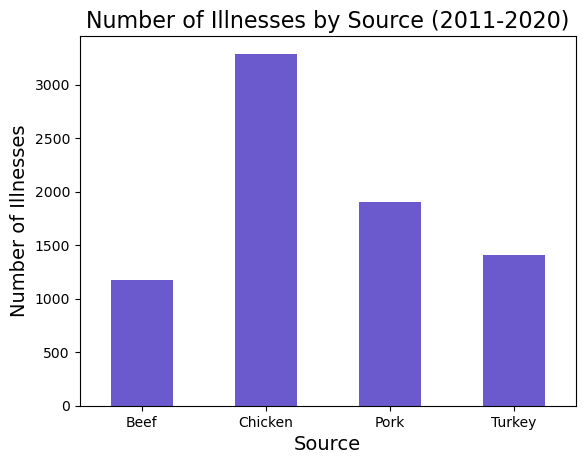

In [91]:
# code originator: Sophia

# plot number of illnesses by source
source_df.plot.bar(rot=0, legend=False, color='slateblue')
plt.xlabel('Source', fontsize = 14)
plt.ylabel('Number of Illnesses', fontsize = 14)
plt.title('Number of Illnesses by Source (2011-2020)', fontsize = 16)
plt.show()

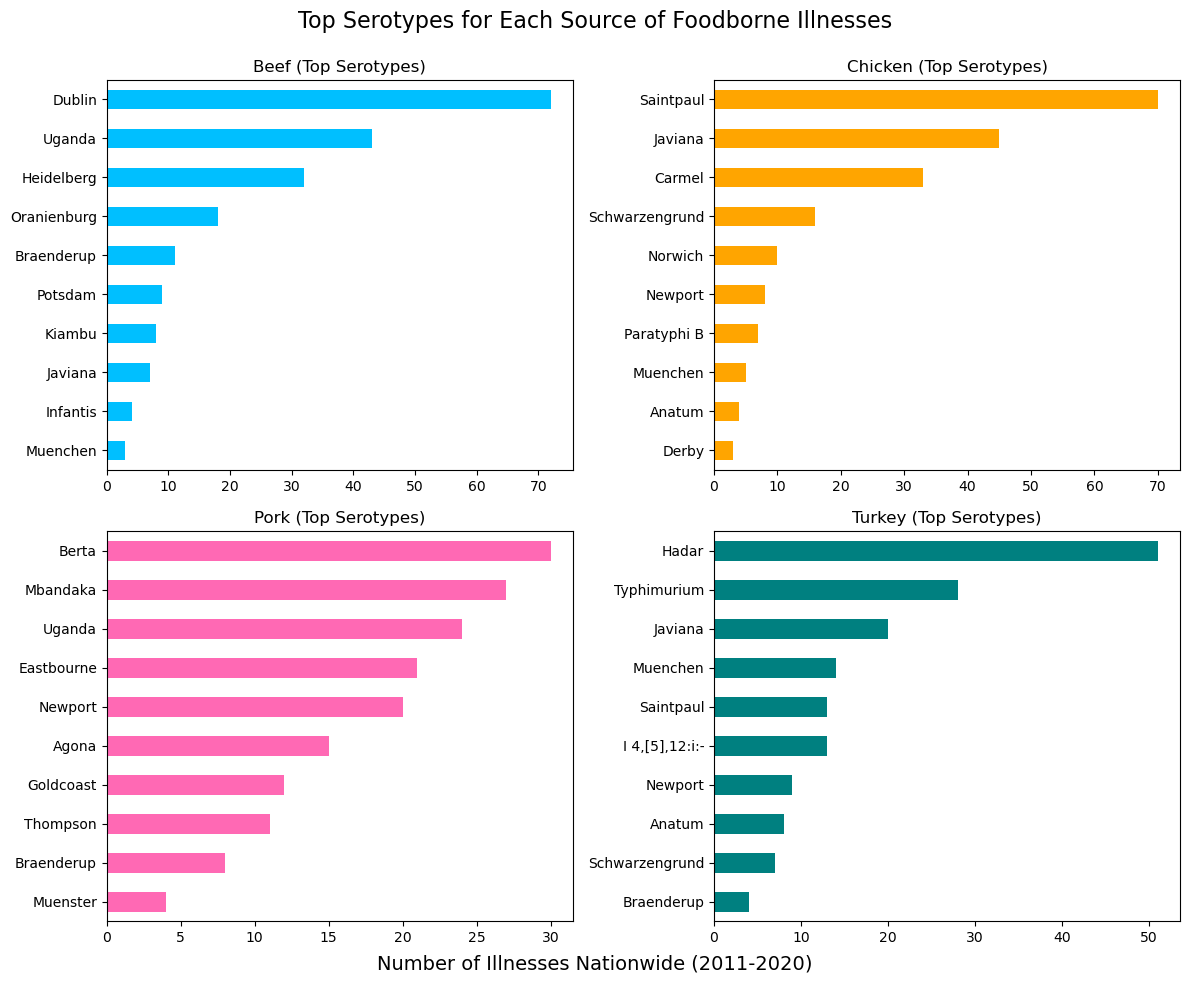

In [92]:
# code originator: Sophia

# filter data for each source
sources = serotype_df['source'].unique()
n_sources = len(sources)

# define color map for each source
color_map = {
    'Beef': 'deepskyblue', 
    'Turkey': 'teal',
    'Chicken': 'orange', 
    'Pork': 'hotpink'
}

# create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # flatten the 2x2 array for easier indexing

# plot each source
for i, source in enumerate(sources):
    # filter data for the current source
    source_df = serotype_df[serotype_df['source'] == source].copy()
    source_df = source_df.sort_values('No_of_illnesses', ascending=True)
    
    # plot the top 10 serotypes
    ax = axes[i]
    source_df.head(10).plot.barh(x='serotype', y='No_of_illnesses', ax=ax, legend=False, color=color_map[source])
    ax.set_title(f'{source} (Top Serotypes)')
    ax.set_ylabel('')

# turn off unused subplots if there are fewer than 4 sources
for j in range(n_sources, len(axes)):
    fig.delaxes(axes[j])

# add overarching labels and title
fig.suptitle('Top Serotypes for Each Source of Foodborne Illnesses', fontsize=16)  # add a figure title
fig.text(0.5, 0.02, 'Number of Illnesses Nationwide (2011-2020)', ha='center', fontsize=14)  # X-axis label for the whole figure
# fig.text(0.01, 0.5, 'Serotype', va='center', rotation='vertical', fontsize=12)  # Y-axis label for the whole figure

# adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # adjust layout to leave space for the title and labels
fig.subplots_adjust(top=0.91)
plt.show()

# Appendix

Initial analysis of pathogen counts per state revealed a strong skew towards states with higher populations, as expected. This is due to the relationship between population density and absolute counts of pathogens.

Additionally, mapping pathogen counts per state provides only a partial view and may overlook critical factors such as population density, healthcare access, or state-level reporting practices.

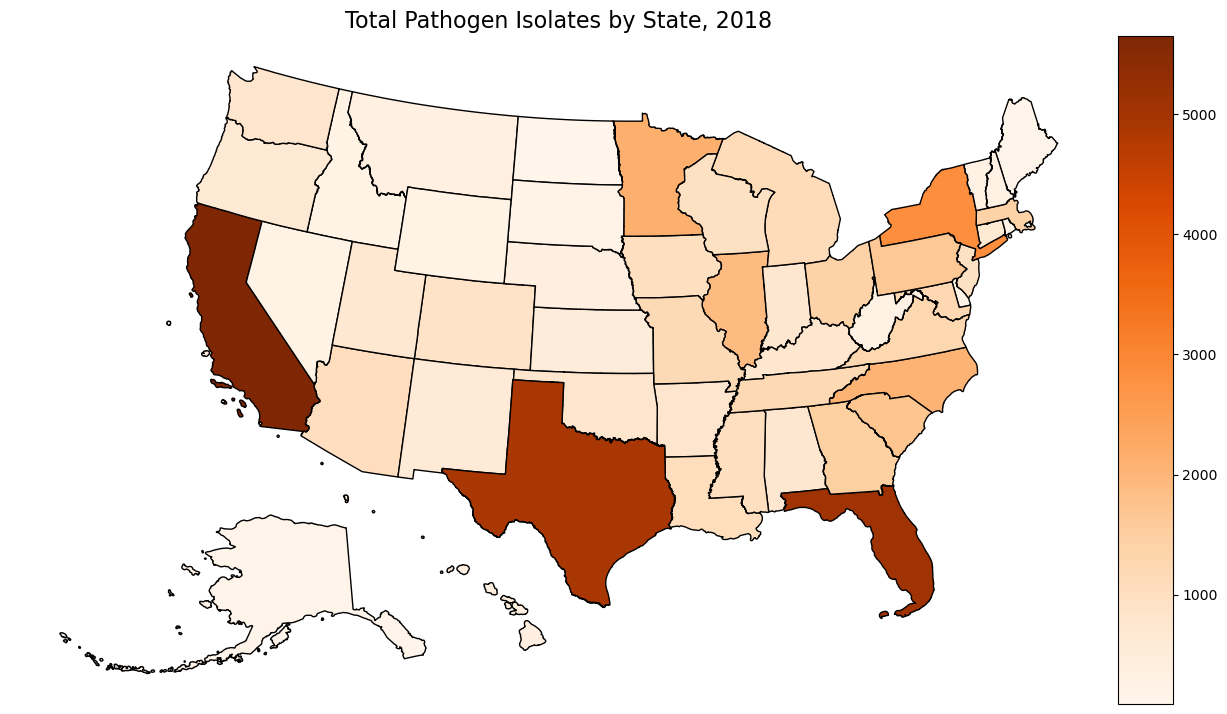

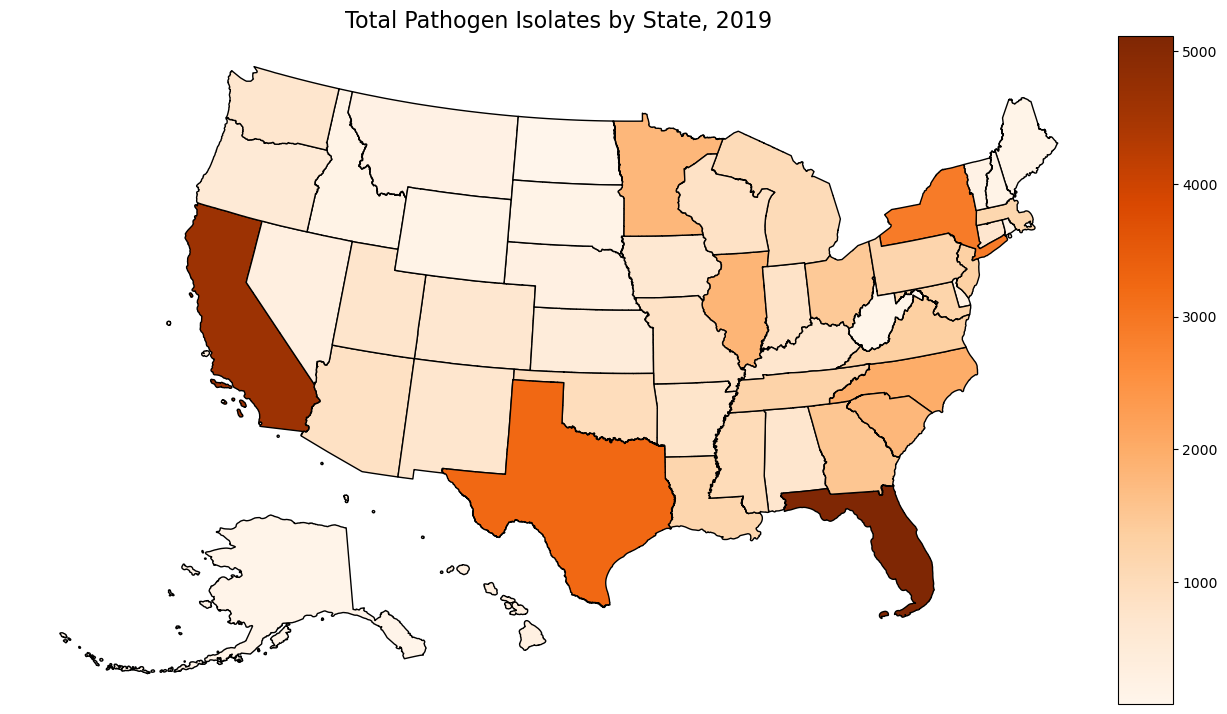

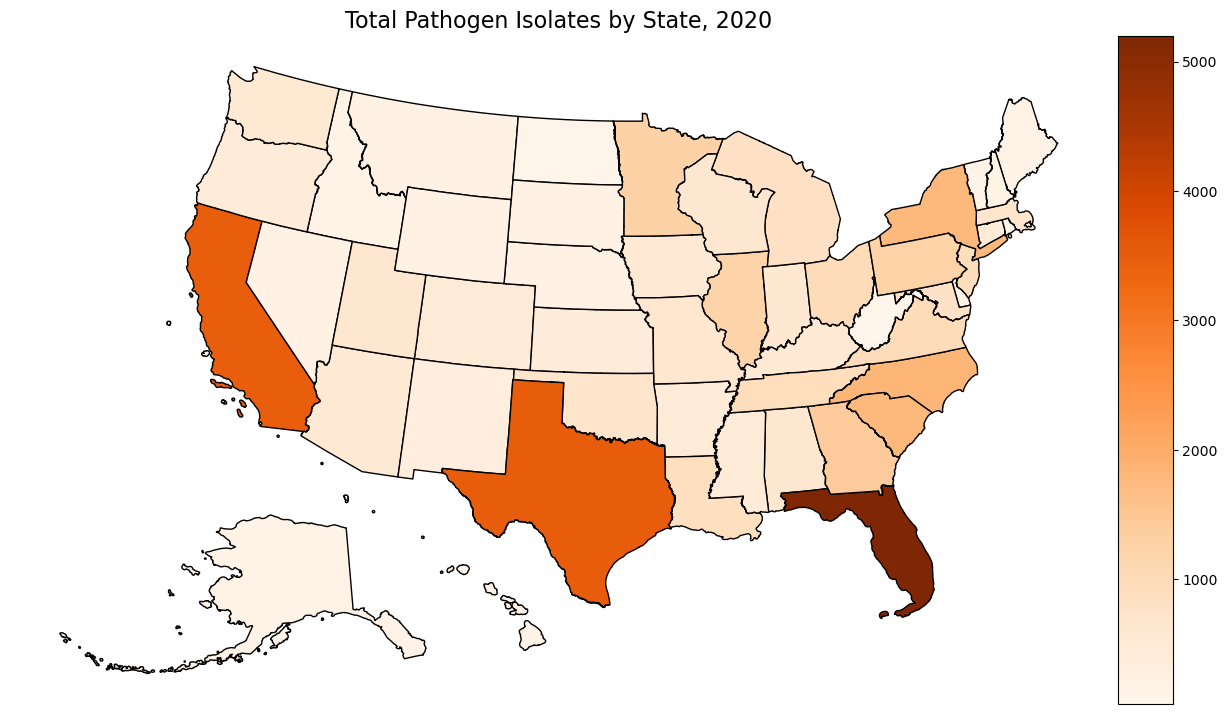

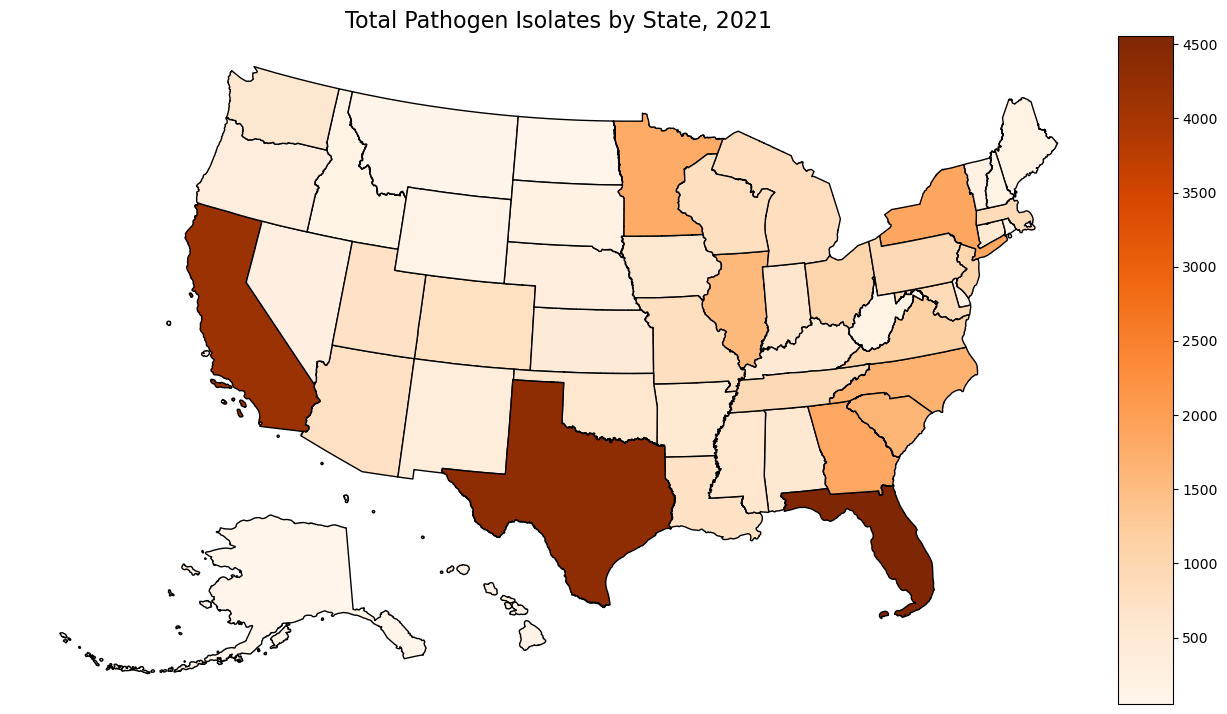

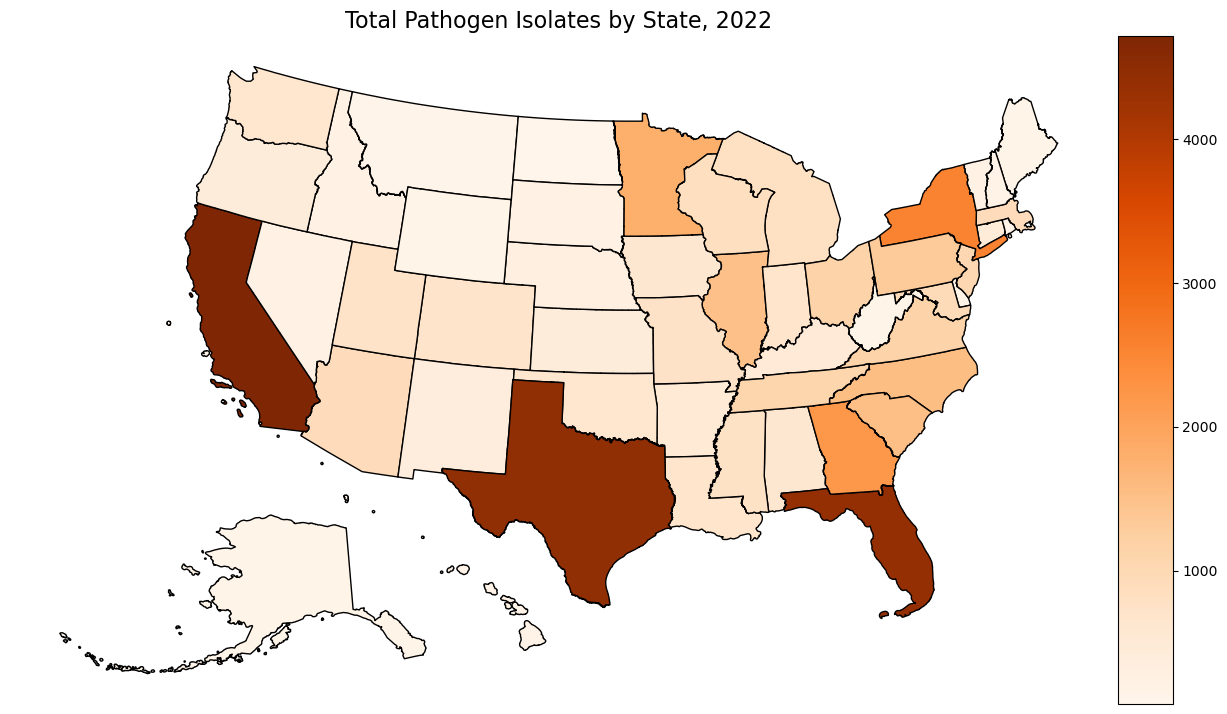

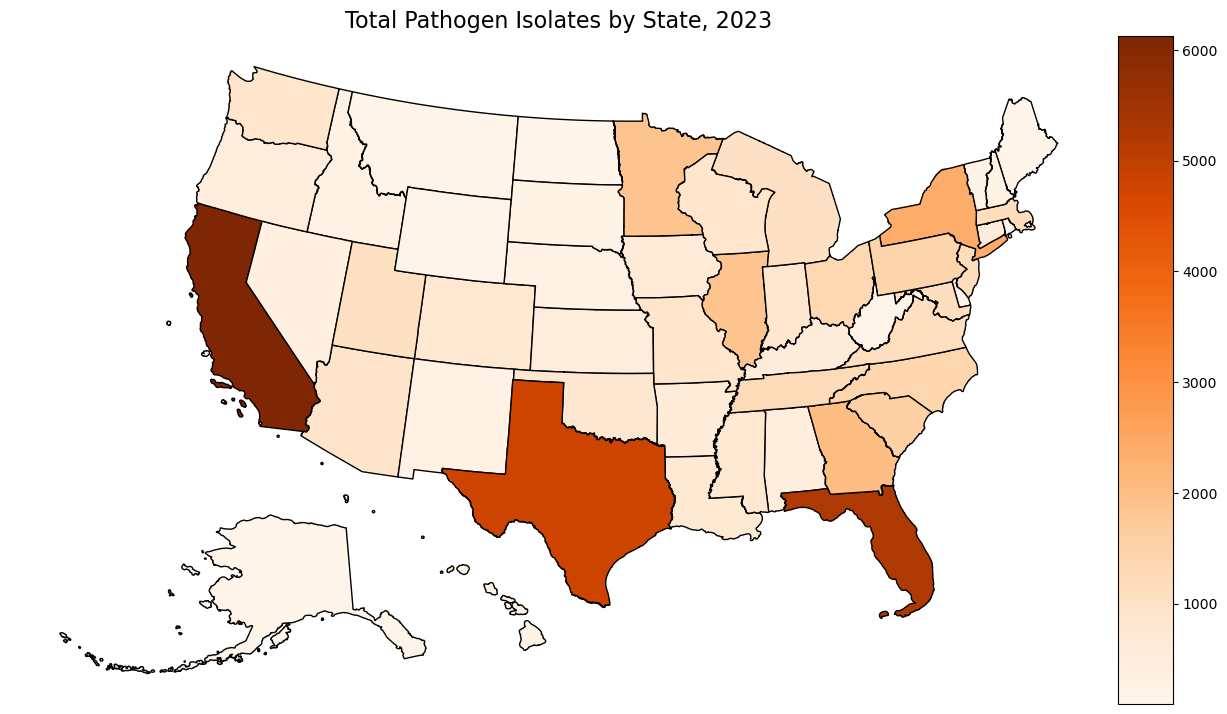

In [93]:
# code originator: Nikki

# maps for each year from 2018 to 2023
years = range(2018, 2024)
for year in years:
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))

    year_data = annual_state_isolates[annual_state_isolates['year'] == year]


    # legend adjustments
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    
    plot = year_data.plot(column='num_isolates', ax=ax, legend=True, cax=cax, cmap = "Oranges", edgecolor = 'black')
    ax.set_title(f'Total Pathogen Isolates by State, {year}', fontsize = 16)
    ax.set_axis_off()
    plt.show()